



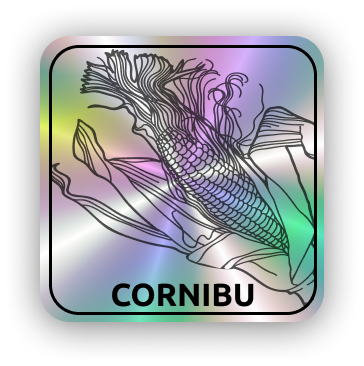



In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.pylab import plot, show, xlim, ylim, axes
import math
from itertools import cycle
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import openalea
from openalea.mtg import *
from openalea.deploy.shared_data import shared_data
import openalea.plantgl.all as pgl
from alinea.caribu.CaribuScene import CaribuScene
from alinea.caribu.data_samples import data_path
import numpy as np
from oawidgets.plantgl import *
from IPython.display import display
from openalea.plantgl.all import *
from oawidgets.plantgl import PlantGL
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from random import randint
from IPython.display import *
import k3d
import numpy as np
from k3d import matplotlib_color_maps
%gui qt	
from PyQGLViewer import *
from alinea.caribu.CaribuScene import CaribuScene
from alinea.caribu.sky_tools import GenSky, GetLight, Gensun, GetLightsSun
from openalea.plantgl.all import *
#from pgljupyter import SceneWidget
from numpy import arange
import matplotlib.pyplot as plt
import shutil
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
from matplotlib.pylab import plot, show, xlim, ylim, axes
import copy
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


def CORNIBU(T, To, DTc, DTs, S_max, N_max, H_max, inter_rang, density, incli_top, incli_base, l, delta, phyllotactic_angle, phyllotactic_deviation, loc, scale, arg, dist, Caribu, vizu, mode, norm, RFR, DOY, latitude) :


    def leafsize(St, it):

    # Inputs:
    # it (Maximum number of leaves)
    # Type: Integer

    # St (Maximum leaf area per plant)
    # Type: Float

    # Outputs:

    # ratio:
    # Type: NumPy array
    # Description: Ratio of leaf width to leaf length.

    # lt:
    # Type: NumPy array
    # Description: Array of leaf lengths.

        matt = []
        for al in range(-1,2,1) :
            w1 = 0.015                                          # First leaf can be assumed to be constant wt(1) = 0.015 m
            l1 = 0.04                                           # First leaf can be assumed to be constant lt(1) = 0.04 m

                                                                # WIDTH
            wtt = []
            i = [i for i in np.arange(1, it+1, 1)]              # it : Maximum number of leaves
            for ii in i :
                iwmax = 1.59+0.65*it                            # Order of the widest leaf 
                wmax = 0.066 - 0.0005*it + 0.085*St               # Width of the widest leaf 
                aw = (wmax - w1)/((iwmax**3 - 3*iwmax + 2) - (3/2)*(iwmax**2-1)*(iwmax-1))
                bw = (-3*aw*(iwmax**2 - 1))/(2*(iwmax - 1))
                wt = aw*(ii**3-3*ii+2) + bw*(ii**2-2*ii+1) + w1 # Function defining the maximum width for each leaf
                wtt.append(wt)
            wt = wtt

                                                                # LENGTH
            lmax = 0.99 - 0.04*it + 0.94*St                     # Length of the longest leaf 
            ilmax = 5.81 + 0.31*it                              # Order of the longest leaf 
            il17 = [i for i in np.arange(0, 7, 1)]
            ilrest = [i for i in np.arange(8, it + 1, 1)]

            alphal = (al*7**2 - 2*al*ilmax*7 + lmax + ilmax**2*al - l1)/(7 - 1)

            lt17 = (np.asarray(alphal)*il17) + l1             # Function defining the length for leaf 1 -> 7
            ltrest = al*np.power(ilrest,2) - 2*np.asarray(al)*np.asarray(ilrest)*ilmax + lmax + np.power(ilmax,2)*al  # Function defining the length for leaf 8 -> it (N_max)
            lt = np.concatenate((lt17, ltrest))

            ajuste=(0.72*np.sum(wt*lt)) - St
            mat = matt.append([al, ajuste])

        mat = np.asarray(matt)
        coef = np.polyfit(mat[:, 0], mat[:, 1], 1)
    
        al=-coef[1]/coef[0]                                     # Ajusting al parameter to get length from width and St

        w1=0.015                                                # Once al fixed, rest can be computed according previous comments
        l1=0.04
        i = [i for i in np.arange(1, it+1, 1)]
        wtt = []
        for ii in i :
            iwmax = 1.59+0.65*it
            wmax = 0.066 - 0.00065*it + 0.085*St
            aw = (wmax - w1)/((iwmax**3 - 3*iwmax + 2) - (3/2)*(iwmax**2-1)*(iwmax-1))
            bw = (-3*aw*(iwmax**2 - 1))/(2*(iwmax - 1))
            wt = aw*(ii**3-3*ii+2) + bw*(ii**2-2*ii+1) + w1
            wtt.append(wt)
        wt = wtt

        lmax=0.99-0.04*it+St
        ilmax=5.81+0.27*it
        il17 = [i for i in np.arange(0, 7, 1)]
        ilrest = [i for i in np.arange(8, it + 1, 1)]
        alphal=(al*7**2-2*al*ilmax*7+lmax+ilmax**2*al-l1)/(7-1)
        lt17 = (np.asarray(alphal)*il17) / 1.5 + l1
        ltrest = al*np.power(ilrest,2) - 2*np.asarray(al)*np.asarray(ilrest)*ilmax + lmax + np.power(ilmax,2)*al
        lt = np.concatenate((lt17, ltrest))
        ratio = wt/lt

        return ratio, lt

    def plante(N_max, S_max, H_max, incli_top, incli_base, l, delta):

    # Inputs:

    # N_max:
    # Type: Integer
    # Description: Number of leaves.

    # S_max:
    # Type: Float
    # Description: Total leaf area of the plant in square meters (m²).
                                                                
    # H_max:
    # Type: Float
    # Description: Height of the plant in meters (m).

    # Outputs:

    # ABC_stem:
    # Type: List of lists (nested lists)
    # Description: Represents the geometry of the stem in 3D space.

    # ABC_leaf:
    # Type: NumPy array
    # Description: Represents the geometry of the leaves in 3D space.

    # s_leaff:
    # Type: NumPy array
    # Description: Surface area of the leaves (for theoretical LAI computation).

    # longueur:
    # Type: NumPy array
    # Description: Represents the length of leaves.

        leaf_shape, longueur = leafsize(S_max, N_max)           # Calculate the shape (ratio length-width) of the leaf and its length

        a = 0.59526                                             # Model parameters from Koetz 2001
        d = 1.4158

        N = np.arange(1, N_max+1)
        S = (1+np.sin((np.pi/a)*((N/N_max)**d)-(np.pi/2)))/2    # Leaf area for each leaf order 
        Summ = S.sum()
        SS = S*S_max/Summ                                       # Normalizing the maximum leaf area produced

        b_leaff = np.sqrt(2*SS*leaf_shape)                      # Base of the leaves (max width as for now leaves will be isoceles triangles)
        h_leaff = np.sqrt(2*SS/leaf_shape)                      # Length of the leaves (as for now leaves will flat in a same direction, parallel to ground)
        s_leaff = b_leaff*h_leaff/2                             # Initialize Surface for isoceles triangles | Useful for theorical LAI computation

        print('surace model', s_leaff)


        Euclidian_distance_length = []
        for Leaf_OI in N :
            x_max, y_max = leaf_shape_rank(rank = Leaf_OI-1, incli_top = incli_top, incli_base = incli_base, l = l, delta = delta, nb_segment = int(longueur[Leaf_OI-1]*100))       # Curvature and inclination function
            Euclidian_distance_length.append(np.abs((x_max[np.argmax(x_max)]-x_max[0])/100))


        ABC_leaf = np.zeros((N_max, 9))                         # Leaves building
        ABC_leaf[:,1] = b_leaff/40
        ABC_leaf[:,3] = Euclidian_distance_length
        ABC_leaf[:,7] = b_leaff/40

        r_stem_N_max = 20*H_max/2.5                             # Stem building
        r_stemm = []

        for i in N :
            r_stemm.append(0.02 + (r_stem_N_max - 0.02)/ (N_max-1)* (i-1))
        ABC_stem = []
        for i in N :
            ABC_stem.append( [[r_stemm[i-1] ,0 ,0, 0 ,r_stemm[i-1] ,0, 0, 0, H_max] , [0, r_stemm[i-1], 0 ,-r_stemm[i-1], 0 ,0, 0 ,0, H_max ], [-r_stemm[i-1] ,0, 0, 0 ,-r_stemm[i-1], 0, 0, 0, H_max], [0, -r_stemm[i-1], 0 ,r_stemm[i-1], 0 ,0, 0, 0 , H_max]] )         

        return ABC_stem, ABC_leaf, s_leaff, longueur



    def rot_3D_triangle(xyz,rotangle) :

    # Inputs:

    # xyz:
    # Type: NumPy array (matrix)
    # Description: A [n 9] matrix of coordinates of n triangles defined by their 3 points [X1 Y1 Z1 X2 Y2 Z2 X3 Y3 Z3].

    # rotangle:
    # Type: NumPy array (matrix)
    # Description: A 3-element matrix for rotation angles, representing rotation about x, y, and z axes respectively.

    # Output:

    # xyz:
    # Type: NumPy array (matrix)
    # Description: The rotated matrix of coordinates.

        try :
            xyz= (xyz.reshape(3,3).transpose()) 
        except : 
            sha = int((xyz.shape[0]* xyz.shape[2])/3)
            xyz= (xyz.reshape(sha,3).transpose())

        ax=rotangle[0]/180*np.pi
        ay=rotangle[1]/180*np.pi
        az=rotangle[2]/180*np.pi

        bx = [[1,0,0], 
            [0, np.cos(ax), np.sin(ax)],
            [0, -np.sin(ax), np.cos(ax)]]

        by = [[np.cos(ay), 0,  -np.sin(ay)], 
            [0, 1, 0],
            [ np.sin(ay) ,0 ,np.cos(ay)]]

        bz = [[np.cos(az) ,np. sin(az), 0], 
                    [-np.sin(az), np.cos(az), 0],
                    [ 0, 0,  1]]

        B = np.asarray(bx)@np.asarray(by)@np.asarray(bz)
        xyz= np.dot(B,xyz)
        n=len(xyz[:,2])
        xyz = (xyz.transpose().flatten()) 

        return xyz


    def leaf_shape(nb_segment, insertion_angle, l, infl):

    # Inputs:

    # nb_segment:
    # Type: Integer
    # Description: Number of segments to divide the leaf shape.

    # insertion_angle:
    # Type: Float
    # Description: The angle at which the leaf is attached to the stem.

    # infl:
    # Type: Float
    # Description: Inflection point for the sigmoid function.

    # l:
    # Type: Float
    # Description: Length of the leaf.

    # Outputs:

    # x:
    # Type: NumPy array
    # Description: x coordinates of the leaf profile.

    # y:
    # Type: NumPy array
    # Description: y coordinates of the leaf profile.

        def _sigmo(x,max,slope,infl):
            # Sigmoid function with a given maximum value, slope, and inflection point
            return(max / (1+np.exp(4*slope*(infl-x))))

        def _curvature(s, coef_curv):
            # Calculate the curvature of the leaf shape based on a given segment length and a coefficient of curvature
            return ((1 + coef_curv) * (s**2)) / (1 + coef_curv * (s**2))

        s = np.linspace(0,1,nb_segment+1)
        frac_l = 2. / 3
        coefCurv_1 = -0.2
        coefCurv_2 = 5

        tip_angle = np.maximum(insertion_angle, _sigmo(x=insertion_angle, max=240, slope=0.02, infl=infl))
        l_angle = insertion_angle + frac_l*(tip_angle - insertion_angle)
        angle_simu_1 = _curvature(s, coef_curv=coefCurv_1) * np.radians(l_angle-insertion_angle) + np.radians(insertion_angle)      # Before curvature break
        angle_simu_2 = _curvature(s[1:], coef_curv=coefCurv_2) * np.radians(tip_angle - l_angle) + np.radians(l_angle)              # After curvature break
        angle_simu=np.array(angle_simu_1.tolist() + angle_simu_2.tolist())
        coef_l=[l]*len(s)+[1-l]*len(s[1:])
        dx = np.array([0] + (coef_l * np.sin(angle_simu)).tolist())[:-1]                                                            # Changes (dx) in the x-coordinates for each segment of the leaf shape
        dy = np.array([0] + (coef_l * np.cos(angle_simu)).tolist())[:-1]                                                            # Changes (dy) in the y-coordinates for each segment of the leaf shape
        x, y = np.cumsum(dx), np.cumsum(dy)

        return x, y


    def leaf_shape_rank(rank, nb_segment, incli_top, incli_base, l, delta):

    # Inputs:

    # rank:
    # Type: Integer
    # Description: Rank of the leaf.

    # nb_segment:
    # Type: Integer
    # Description: Number of segments to divide the leaf shape.

    # incli_top:
    # Type: Float
    # Description: Inclination from the highest leaf.

    # incli_base:
    # Type: Float
    # Description: Inclination from the lowest leaf.

    # l:
    # Type: Float
    # Description: Length leaf ratio where curvature occurs.

    # delta:
    # Type: Float
    # Description: Curvature governed by the intersection between leaf insertion angle and leaf tip angle.

    # Output:

    # Returns the result of calling the function leaf_shape() with specific parameters.

        phytomer=16
        dinc = float(incli_top - incli_base) / (phytomer - 1)
        incli = incli_base + (rank -1) * dinc
        
        tip_angle = incli_base + delta
        a = np.log(240/tip_angle - 1)
        b = 4*0.02
        infl = a / b + incli_base

        return leaf_shape(nb_segment = nb_segment, insertion_angle = incli, l=l, infl=infl)


    def leaf_morpho_rel(nb_segment=100, w0=0.5, lm=0.5):

    # Inputs:

    # nb_segment:
    # Type: Integer
    # Default: 100
    # Description: Number of segments to divide the leaf shape.

    # w0:
    # Type: Float
    # Default: 0.5
    # Description: Parameter for leaf shape calculation.

    # lm:
    # Type: Float
    # Default: 0.5
    # Description: Parameter for leaf shape calculation.

    # Outputs:

    # s:
    # Type: NumPy array
    # Description: Linear space array ranging from 0 to 1.

    # r:
    # Type: NumPy array
    # Description: Array representing the radial shape of the leaf lamina.

        # Half leaf lamina shape according to oil palm model from Perez 2016
        a0 = w0
        c0 = (w0 - 1) / (lm ** 2)
        b0 = -2 * c0 * lm

        c1 = -1 / (1 - lm) ** 2
        b1 = -2 * c1 * lm
        a1 = -b1 - c1

        s = numpy.linspace(0, 1, nb_segment + 1)
        r1 = numpy.array(a0+b0*s[s <=lm]+c0*s[s <=lm]**2)
        r2 = numpy.array(a1+b1*s[s >lm]+c1*s[s >lm]**2)
        r = numpy.concatenate([r1,r2])

        return s, r


    def leaf_azimuth(size, phyllotactic_angle, phyllotactic_deviation, plant_orientation):
    
    # Inputs:

    # size:
    # Type: Integer
    # Description: Number of leaves.

    # phyllotactic_angle:
    # Type: Float
    # Description: Angle between successive leaves.

    # phyllotactic_deviation:
    # Type: Float
    # Description: Deviation from the main azimuth direction.

    # plant_orientation:
    # Type: Float
    # Description: The orientation of the plant.

    # Outputs:

    # azim:
    # Type: NumPy array
    # Description: Array of azimuth angles for each leaf.
    

        elements = [plant_orientation, np.mod(360-(plant_orientation + 180), 360)]
        probabilities = [0.5, 0.5]
        plant_orientation = np.random.choice(elements, 1, p=probabilities)

        if size == 1:
            return plant_orientation[0]
            
        main = np.arange(0, size) * phyllotactic_angle
        azim = (plant_orientation + main + np.random.uniform(-1, 1, size) * phyllotactic_deviation) % 360

        return azim
    
    def read_data(data):

    # Inputs:

    # data:
    # Type: String
    # Description: Path to the .txt file containing the data.

    # Output:

    # xyz:
    # Type: NumPy array
    # Description: An array containing the parsed data.

        xyz = list()
        with open(data, 'r') as data:
            for line in data:
                values = [float(v) for v in line.split()[:3]] 
                xyz.append(tuple(values))
        data.close()
        return numpy.array(xyz)


    def triangle_area(x1, x2, x3, y1, y2, y3, z1, z2, z3):

    # Inputs:

    # x1, x2, x3, y1, y2, y3, z1, z2, z3:
    # Type: Float
    # Description: Coordinates of the vertices of the triangle.

    # Output:

    # area:
    # Type: Float
    # Description: The area of the triangle.

        ux, uy, uz = x2-x1, y2-y1, z2-z1
        vx, vy, vz = x3-x1, y3-y1, z3-z1
        cx, cy, cz = uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx
        magnitude = (cx**2 + cy**2 + cz**2)**0.5
        return 0.5 * magnitude

    #####################################################################################################################################################################################################################################################
    ##########################################################################################################     FIN UTILS FUNCTIONS      #############################################################################################################
    #####################################################################################################################################################################################################################################################


    if 5/(inter_rang*5*density) > inter_rang :                  # Test if distance between plants is higher than distance between rows, if yes, distance between plants will become distance between rows. Reciprocally
        inter_rang=5/(inter_rang*5*density)

    scene_side = inter_rang*5                                   # Scene length will be defined by 5 rows

    [ABC_stem, ABC_leaf, area_shape, longueur] = plante(N_max,S_max,H_max, incli_top, incli_base, l, delta)  # Whole 'mean' plante computation | area_shape for LAI computation

    N = [i for i in np.arange(1, N_max+1, 1)]

    import numpy.matlib
    T = np.matlib.repmat(T, N_max+1,1)

    Growth = [((To + i*DTc < T[i]) and (To + i*DTc + DTs > T[i]))[0] for i in N] # Originally calculation of the order of potentially present leaves - not used in our case as we focused on single date | Calculation of the leaf presence vector

    I = np.argwhere(np.asarray(Growth)==1)
    ABC_leaf = ABC_leaf[I,:]

    dist_plt = 5/(scene_side*density)                           # Distance between plants within row

    Li = np.arange(dist_plt/2, scene_side, dist_plt)            # x,y center position of each plant in scene
    y = np.tile(Li,5)
    Lix = np.arange(inter_rang/2, scene_side, inter_rang)
    x = np.tile(Lix,len(y/5))
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    xx, yy = np.meshgrid(x_unique, y_unique)
    xyz = np.stack((xx, yy, np.zeros_like(xx)), axis=-1).reshape(-1, 3)

    xydelta = 0.1                                               # Related to noise soowiing parameter
    delta_teta_leaf = 20                                        # Initialize difference in inclination between the first and the largest leaf
    teta_biggest = 45                                           # Initialize inclination of largest leaf
    rand_teta = 2.5                                             # Noise (°) in inclination for each leafx_vec_g

    newy = (np.random.rand(len(xyz), 1)*xydelta*2*dist_plt) - (dist_plt*xydelta/2)    # Deviation plants from row x, y noise
    np.asarray(xyz)[:, 1] += newy[:, 0]
    xyz[:, 0] += newy[:, 0]
    area_soil = np.abs(xyz[0][0] - xyz[-1][0]) * np.abs(xyz[0][1] - xyz[-1][1])
        
    ABC_couvert = []
    DEF_couvert = []
    N = [i for i in np.arange(1, N_max+1, 1)]
    a=0.59526
    d=1.4158

    SS = []

    N = [i for i in np.arange(1, N_max+1, 1)]
    for i in N :
        S = (1+np.sin((np.pi/a)*((i/N_max)**d)-(np.pi/2)))/2
        SS.append(np.asarray(S)*S_max/np.sum([S for i in N]))                         # Leaf area for each leaf order | Normalizing the maximum leaf area produced (redondance with previous plant function only for LAI computation accessibility)

    N_biggest = np.argwhere(SS == np.max(SS))
    SS = SS - SS[0]
    SS = (SS[N_biggest[0][0]] - SS) / SS[N_biggest[0][0]]

    a = 3.7 - 0.10*N_max - 0.36*S_max                                                  
    H = (H_max - 0.015) / np.power(N_max,a-1) * np.power(N,a-1) + 0.015               # Heigth of first leaf | Insertion heigth of all leaves Espana 1998
    H = H/1.5

    teta_mat=[]
    Post_Azi = []
    Leaf_Tri_Count = []

    SUR_TOT = np.sum(area_shape) * len(xyz)                                           # Total surface (LAI computation) 

    for p in range(len(xyz)) :                                                        # For each plant

        teta_leaf = SS*delta_teta_leaf + teta_biggest + (np.random.randn(N_max,1)*rand_teta - rand_teta/2)          # Calculation of initial inclination
        ABC_leafind = copy.deepcopy(ABC_leaf)                                                                       # Careful Python language tricks

        if p == 0 :
            teta_mat = teta_leaf[0]
        else :
            teta_mat = np.column_stack((teta_mat,teta_leaf[0]))

                                                                                      # Inclusion of explicit distributions
        dist = getattr(scipy.stats, dist_func)
        try :
            mOR = dist.rvs(loc=loc, scale=scale, *arg, size = 1)                      # Dealing with several *args length according to selected distribution
        except :
            arg = [arg]
            mOR = dist.rvs(loc=loc, scale=scale, *arg, size = 1)
     
        mOR = mOR[0]

        while mOR < 0 or mOR > 90 :                                                   # Dealing with continuous/discrete distributions ranges
            mOR = dist.rvs(loc=loc, scale=scale, *arg, size = 1)
            mOR = mOR[0]                                                              # mOR : Main azimuthal direction of plant p, selected according to theorical distribution

        az_max = (leaf_azimuth(size = N_max, phyllotactic_angle = phyllotactic_angle, phyllotactic_deviation = phyllotactic_deviation, plant_orientation = (90 - mOR)) ) * np.pi/180    # Rearrange all leaves according to phyllotactic angle 


        N = [i for i in np.arange(1, N_max+1, 1)] 
        for n_leaf in N  :
            Post_Azi.append(math.degrees(az_max[n_leaf-1]))
            ABC_leafind[n_leaf-1,:] = rot_3D_triangle(ABC_leafind[n_leaf-1,:], [0, 0, 0])                                   # Rotation for leaf inclination
            ABC_leafind[n_leaf-1,:] = rot_3D_triangle(ABC_leafind[n_leaf-1,:], [0, 0, math.degrees(az_max[n_leaf-1])])      # Rotation for leaf azimuth
            ABC_leafind[n_leaf-1,:] = ABC_leafind[n_leaf-1,:] + [0, 0, H[n_leaf-1], 0, 0, H[n_leaf-1], 0, 0, H[n_leaf-1]]   # Rotation for plant azimuth

        ABC_leafind = ABC_leafind.reshape(N_max,9)
        
        ABC = ABC_leafind                                                                                                   # Leaves matrix
        ABC_couvert = ABC + np.tile(xyz[p,:],(len(ABC),3)) if p == 0 else np.vstack([ABC_couvert, ABC + np.tile(xyz[p,:],(len(ABC),3)) ])

        DEF = ABC_stem[0]                                                                                                   # Stem matrix
        DEF_couvert = DEF + np.tile(xyz[0,:],(len(DEF),3))
        for p in range(1, len(xyz)):
            DEF_couvert = np.vstack([DEF_couvert, DEF + np.tile(xyz[p,:],(len(DEF),3)) ])

    
    Stacked_facets = []
    ALA_ratio =  [] 
                                                      
    incli_base = (incli_base + (np.random.randn(1,1) * rand_teta))[0][0]                # Randomness leaves inclination + curvature on 4 parameters 
    delta = (delta + (np.random.randn(1,1) * rand_teta))[0][0]
    l = (l + (np.random.randn(1,1) * 0.05))[0][0]


    for n_leaf in range(len(ABC_couvert))  :     

        Stacked_facets_corr = []                                                                           # Rework on each leaf (flat and inclined for now)

        Leaf_OI = np.mod(n_leaf, N_max)   
        x_max, y_max = leaf_shape_rank(rank = Leaf_OI, incli_top = incli_top, incli_base = incli_base, l = l, delta = delta, nb_segment = int(longueur[Leaf_OI]*100))       # Curvature and inclination function

        angle = math.atan2(np.median(y_max), np.median(x_max))
        angle_degrees = math.degrees(angle)

        def calculate_value(value):
            if 0 <= value <= 90:
                return 90 - value
            else:
                return 90 + abs(value)

        fin = calculate_value(np.mean(angle_degrees))
        ALA_ratio.append(fin)
    

        x_vec_g = (x_max/100 * math.cos(np.radians(Post_Azi[n_leaf])))+ ABC_couvert[n_leaf][0]
        y_vec_g = (x_max/100 * math.sin(np.radians(Post_Azi[n_leaf]))) + ABC_couvert[n_leaf][1]

        x_vec_d = (x_max/100 * math.cos(np.radians(Post_Azi[n_leaf]))) + ABC_couvert[n_leaf][6]
        y_vec_d = (x_max/100 * math.sin(np.radians(Post_Azi[n_leaf]))) + ABC_couvert[n_leaf][7]

        z_vec_g = ABC_couvert[n_leaf][2] + y_max/100
        z_vec_g_corr = ABC_couvert[n_leaf][2] + y_max/100

        z_vec_d = z_vec_g
        xin_array = np.linspace(0, int(longueur[Leaf_OI]*100), len(y_max))                                                  # Waffling function TODO : Non prehistoric function !
        yout_array = np.sin(xin_array/ (Leaf_OI/1.25))* 0.01
        z_vec_g = z_vec_g + yout_array
        
        yout_array = np.sin(-xin_array/ (Leaf_OI/1.25))* 0.01
        z_vec_d = z_vec_d - yout_array

        leaf_area = area_shape[Leaf_OI] / 2                                                                              # Lamina shape

        w0=0.5+0.01*Leaf_OI
        lm=0.5+(-.02)*Leaf_OI
        wl_min=0.08+Leaf_OI*0.001

        s,r=leaf_morpho_rel(nb_segment=len(x_max)-1, w0=w0, lm=lm) 

        l_min= longueur[Leaf_OI] 
        w_min=l_min*wl_min
        s_min,r_min = s*l_min, r*w_min

        integral = np.trapz(r_min,s_min)
        w_min = w_min * (leaf_area / integral)
        s_min,r_min = s*l_min, (r*w_min)
      

        px_p = np.empty(len(x_vec_g))
        py_p = np.empty(len(y_vec_g))
        px_n = np.empty(len(x_vec_g))
        py_n = np.empty(len(y_vec_g))
        for idx in range(len(x_vec_g)-1):
            x0, y0, xa, ya = x_vec_g[idx], y_vec_g[idx], x_vec_g[idx+1], y_vec_g[idx+1]
            dx_p, dy_p = xa-x0, ya-y0
            norm_p = np.hypot(dx_p, dy_p) * 1/r_min[idx]
            px_p[idx] = x0-dy_p/norm_p
            py_p[idx] = y0+dx_p/norm_p

            dx_n, dy_n = xa-x0, ya-y0
            norm_n = np.hypot(dx_n, dy_n) * 1/-r_min[idx]
            px_n[idx] = x0-dy_n/norm_n
            py_n[idx] = y0+dx_n/norm_n

        x_vec_g_corr = np.insert(px_p, 0, px_p[0])
        y_vec_g_corr = np.insert(py_p, 0, py_p[0])
        x_vec_d_corr = np.insert(px_n, 0, px_n[0])
        y_vec_d_corr = np.insert(py_n, 0, py_n[0])


        pp = np.arange(len(x_max)-1)
        Stacked_facets_corr.append([x_vec_g_corr[pp], x_vec_g_corr[pp+1], x_vec_d_corr[pp], y_vec_g_corr[pp], y_vec_g_corr[pp+1], y_vec_d_corr[pp], z_vec_g_corr[pp], z_vec_g_corr[pp+1], z_vec_g_corr[pp]])                 # Facets triangles building
        Stacked_facets_corr.append([x_vec_g_corr[pp+1], x_vec_d_corr[pp+1], x_vec_d_corr[pp], y_vec_g_corr[pp+1], y_vec_d_corr[pp+1], y_vec_d_corr[pp], z_vec_g_corr[pp+1], z_vec_g_corr[pp+1], z_vec_g_corr[pp]])


        cumulative_area = 0
        for triangle in np.concatenate(Stacked_facets_corr, axis=1).T.tolist() :
            x1, x2, x3, y1, y2, y3, z1, z2, z3 = triangle
            area = triangle_area(x1, x2, x3, y1, y2, y3, z1, z2, z3)
            cumulative_area += area
        

        leaf_area = area_shape[Leaf_OI] / 2                                                                              # Lamina shape

        w0=0.5+0.01*Leaf_OI
        lm=0.5+(-.02)*Leaf_OI
        wl_min=0.08+Leaf_OI*0.001

        s,r=leaf_morpho_rel(nb_segment=len(x_max)-1, w0=w0, lm=lm) 

        l_min= longueur[Leaf_OI] 
        w_min=l_min*wl_min
        s_min,r_min = s*l_min, r*w_min

        integral = np.trapz(r_min,s_min)
        w_min = w_min * (leaf_area / integral)
        s_min,r_min = s*l_min, (r*w_min)* (area_shape[Leaf_OI] / cumulative_area)

        px_p = np.empty(len(x_vec_g))
        py_p = np.empty(len(y_vec_g))
        px_n = np.empty(len(x_vec_g))
        py_n = np.empty(len(y_vec_g))
        for idx in range(len(x_vec_g)-1):
            x0, y0, xa, ya = x_vec_g[idx], y_vec_g[idx], x_vec_g[idx+1], y_vec_g[idx+1]
            dx_p, dy_p = xa-x0, ya-y0
            norm_p = np.hypot(dx_p, dy_p) * 1/r_min[idx]
            px_p[idx] = x0-dy_p/norm_p
            py_p[idx] = y0+dx_p/norm_p

            dx_n, dy_n = xa-x0, ya-y0
            norm_n = np.hypot(dx_n, dy_n) * 1/-r_min[idx]
            px_n[idx] = x0-dy_n/norm_n
            py_n[idx] = y0+dx_n/norm_n
        x_vec_g = np.insert(px_p, 0, px_p[0])
        y_vec_g = np.insert(py_p, 0, py_p[0])
        x_vec_d = np.insert(px_n, 0, px_n[0])
        y_vec_d = np.insert(py_n, 0, py_n[0])


        Leaf_Tri_Count.append(np.arange(1, (len(x_max)-1)*2+1))
  
        pp = np.arange(len(x_max)-1)
        Stacked_facets.append([x_vec_g[pp], x_vec_g[pp+1], x_vec_d[pp], y_vec_g[pp], y_vec_g[pp+1], y_vec_d[pp], z_vec_g[pp], z_vec_g[pp+1], z_vec_g[pp]])                 # Facets triangles building
        Stacked_facets.append([x_vec_g[pp+1], x_vec_d[pp+1], x_vec_d[pp], y_vec_g[pp+1], y_vec_d[pp+1], y_vec_d[pp], z_vec_g[pp+1], z_vec_g[pp+1], z_vec_g[pp]])

    
    Stacked_facets = np.concatenate(Stacked_facets, axis=1).T.tolist()                                                                                                                # Stacked list of all facets

    ALA = np.mean(ALA_ratio)
    
    diff_stem_leaves = len(Stacked_facets * 3)                                                                                                                             # 3 being number of vertices for a triangle

    for tt in DEF_couvert :
        Stacked_facets.append( [tt[0], tt[3], tt[6], tt[1], tt[4], tt[7], tt[2], tt[5], tt[8]] )                                                                           # Adding stems triangles

    Stacked_facets.append([xyz[0][0] - inter_rang/2, xyz[-1][0] + inter_rang/2, xyz[0][0] - inter_rang/2, xyz[0][1] - dist_plt/2, xyz[0][1] - dist_plt/2, xyz[-1][1] + dist_plt/2, 0, 0, 0])            # Soil BBox
    Stacked_facets.append([xyz[-1][0] + inter_rang/2, xyz[0][1] - dist_plt/2, xyz[-1][0] + inter_rang/2, xyz[-1][0] + inter_rang/2, xyz[-1][1] + dist_plt/2, xyz[0][0] - inter_rang/2, 0, 0, 0])


    semis = len(xyz)

    for position in xyz :

        def randompoint(ndim=3):
            vec = np.random.randn(ndim,1)
            vec /= np.linalg.norm(vec, axis=0)
            return vec

        a, b, c = 0.05, 0.05, 0.2

        f = lambda x,y,z : np.multiply(np.array([a,b,c]),np.array([x,y,z]))

        def keep(x, y, z, a=a, b=b, c=c):
            mu_xyz = ((a * c * y) ** 2 + (a * b * z) ** 2 + (b * c * x) ** 2) ** 0.5
            return mu_xyz / (b * c) > np.random.uniform(low=0.0, high=1.0)

        n = 500
        points = []
        while len(points) < n:
            [x], [y], [z] = randompoint()
            if keep(x, y, z):
                points.append(f(x, y, z))

        for bille in points : 

            # import numpy as np
            # import matplotlib.pyplot as plt
            # from mpl_toolkits.mplot3d.art3d import Poly3DCollection



            def create_sphere(num_points=100, center=(0, 0, 0), radius=1.0):
                phi = np.linspace(0, np.pi, num_points)
                theta = np.linspace(0, 2 * np.pi, num_points)
                phi, theta = np.meshgrid(phi, theta)

                x = center[0] + radius * np.sin(phi) * np.cos(theta)
                y = center[1] + radius * np.sin(phi) * np.sin(theta)
                z = center[2] + radius * np.cos(phi)

                return x, y, z

            def generate_facets(x, y, z):
                facets = []
                num_points_phi, num_points_theta = x.shape

                for i in range(num_points_phi - 1):
                    for j in range(num_points_theta - 1):
                        v1 = (x[i, j], y[i, j], z[i, j])
                        v2 = (x[i, j + 1], y[i, j + 1], z[i, j + 1])
                        v3 = (x[i + 1, j], y[i + 1, j], z[i + 1, j])

                        facets.append((v1, v2, v3))

                        v1 = (x[i, j + 1], y[i, j + 1], z[i, j + 1])
                        v2 = (x[i + 1, j + 1], y[i + 1, j + 1], z[i + 1, j + 1])
                        v3 = (x[i + 1, j], y[i + 1, j], z[i + 1, j])

                        facets.append((v1, v2, v3))

                return facets 

            num_points = 7
            center = (position[0] + bille[0] + np.random.uniform(-0.005, 0.005), position[1] + bille[1] + np.random.uniform(-0.005, 0.005), bille[2] + H_max + np.random.uniform(-0.005, 0.005)) 
            radius = 0.01
            x, y, z = create_sphere(num_points, center, radius)
            facets = generate_facets(x, y, z)
            
            for facet in facets:
                aa = []
                for vertex in facet:
                    aa.append(np.asarray(vertex))

                fac = np.concatenate(aa)

                num_points = len(fac) // 3
                facc = []
                for i in range(num_points):
                    facc.extend([fac[i], fac[i + num_points], fac[i + 2 * num_points]])

                # facc = facc + np.random.uniform(-0.005, 0.005, size=facc.shape)

                Stacked_facets.append(facc)

    
    BBox = [ (DEF_couvert[0][0] - inter_rang/2), (DEF_couvert[0][1] - dist_plt), (DEF_couvert[-1][0] + inter_rang/2), (DEF_couvert[-1][1] + dist_plt) ]                    # Normal BBox Dir. NS
    area_soil_LAI = (np.abs((DEF_couvert[0][0] - inter_rang/2) - (DEF_couvert[-1][0] + inter_rang/2)) * (np.abs((DEF_couvert[0][1] - dist_plt) - (DEF_couvert[-1][1] + dist_plt))))

    np.savetxt('/home/capte-gpu-2/Downloads/OOO.txt', Stacked_facets)                                                                                                      # 1 row : [3 vertices x 3 coordinates xxxyyyyzzz]                                        

    #####################################################################################################################################################################################################################################################
    ##########################################################################################################     TRANSFO      #########################################################################################################################
    #####################################################################################################################################################################################################################################################

    with open('/home/capte-gpu-2/Downloads/OOO.txt', 'r') as f_input, open('/home/capte-gpu-2/Downloads/OOOC.txt', 'w') as f_output:
        for line in f_input:
            xyz = line.split()
            for triple in zip(xyz[0:3], xyz[3:6], xyz[6:9]):
                f_output.write(' '.join(triple) + '\n')

    data = read_data("/home/capte-gpu-2/Downloads/OOOC.txt")                                                                                                              # 3 rows : [1 vertex x 3 coordinates xyz]  

    shutil.copy("/home/capte-gpu-2/Downloads/OOOC.txt", "/home/capte-gpu-2/Downloads/2023/SORGHUM" + ".txt") #VALID ORTHO A DELETE

    a = []
    composite_list = [data[x:x + 3] for x in range(0, len(data), 3)]                                                  # .can (Chelle) structure transformation | Please read CanestraDoc.pdf given in repo

    shutil.copy("/home/capte-gpu-2/Downloads/OOOC.txt", "/home/capte-gpu-2/Downloads/OOOC.can") #
    text_file = open("/home/capte-gpu-2/Downloads/OOO_CAN.can", "w")

    Leaf = 1
    Plante = 1
    Stem = 1
    Stem_Tri = 1

    tri_counts = np.concatenate(Leaf_Tri_Count)
    for i in range(len(composite_list)):
        tri_type = 1 if i*3 < diff_stem_leaves else 2
        if tri_type == 2:
            if Stem_Tri == 5:
                Stem_Tri = 1
                Stem += 1
            id_str = '2' + str(Stem).zfill(5) + '00000' + str(Stem_Tri)
            Stem_Tri += 1
        else:
            if i != 0:
                if tri_counts[i] == 1:
                    Leaf += 1
                    if Leaf == N_max + 1:
                        Leaf = 1
                        Plante += 1
            id_str = '1' + str(Plante).zfill(5) + str(Leaf).zfill(3) + str(int(tri_counts[i])).zfill(3)
        with open("/home/capte-gpu-2/Downloads/OOO_CAN.can", "a") as text_file:
            exestr = 'p' + ' ' + '2' + ' ' + id_str + ' ' + '9' + ' ' + '3'
            for j in range(3):
                exestr += ' ' + str(composite_list[i][j][0]) + ' ' + str(composite_list[i][j][1]) + ' ' + str(composite_list[i][j][2])
            text_file.write(exestr + '\n')


    limit1 = 72*n*semis + 2
    limit2 = 72*n*semis 

    # SOIL
    with open('/home/capte-gpu-2/Downloads/OOO_CAN.can', 'r') as file:
        lines = file.readlines()
        # last_lines = lines[-4:-2]
        last_lines = lines[-limit1:-limit2]
        modified_lines = []

        idx = 0
        for line in last_lines:
            elements = line.strip().split()

            if idx == 0 :
                    elements[2] = '300001000001'
            else : 
                    elements[2] = '300001000002'

            modified_line = ' '.join(elements) + '\n'
            modified_lines.append(modified_line)
            idx = idx + 1

        lines[-limit1:-limit2] = modified_lines
        with open('/home/capte-gpu-2/Downloads/OOO_CAN.can', 'w') as file:
            file.writelines(lines)


    # PANICLE
    with open('/home/capte-gpu-2/Downloads/OOO_CAN.can', 'r') as file:
        lines = file.readlines()
        # last_lines = lines[-2:]
        last_lines = lines[-limit2:]
        modified_lines = []

        idx = 0
        for line in last_lines:
            elements = line.strip().split()

            if idx == 0 :
                    elements[2] = '400001000001'
            else : 
                    elements[2] = '400001000002'

            modified_line = ' '.join(elements) + '\n'
            modified_lines.append(modified_line)
            idx = idx + 1

        lines[-limit2:] = modified_lines
        with open('/home/capte-gpu-2/Downloads/OOO_CAN.can', 'w') as file:
            file.writelines(lines)
            

    #####################################################################################################################################################################################################################################################
    ##########################################################################################################     CARIBU      ##########################################################################################################################
    #####################################################################################################################################################################################################################################################


    if Caribu == 'y' :

        def Direct(norm, RFR, DOY, latitude, mode):                                       # Direct radiation

            par = data_path('par_panel.opt')                                              # Spectra leaf properties
            nir = data_path('nir.opt')
            opts = ['/home/capte-gpu-2/anaconda3/envs/adel/lib/python3.8/site-packages/alinea.caribu-8.0.7-py3.8.egg/alinea/caribu/data/par_panel.opt']#, '/home/capte-gpu-2/anaconda3/envs/adel/lib/python3.8/site-packages/alinea.caribu-8.0.7-py3.8.egg/alinea/caribu/data/nir.opt']
            
            # Creates sun
            energy = 1                                                              # PAR | Q | Irradiance
            DOY = DOY                                                               # Day Of Year
            latitude = latitude                                                     # Lat.

            for i in range(5,20) : #6, 20                                            # Hours concerned

                getsun = GetLightsSun.GetLightsSun(Gensun.Gensun()(energy, DOY, i, latitude)).split(' ')                    # Sun position according to hour, day, Lat., energy
                sun = tuple((float(getsun[0]), tuple((float(getsun[1]), float(getsun[2]), float(getsun[3])))))

                ### ROTATION SUN PATH TO SIMULATE EXPERIMENT ROW DIRECTION FACED TO NS DIRECTION ###
                # theta_z = np.deg2rad(-42)
                # Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                #             [np.sin(theta_z), np.cos(theta_z), 0],
                #             [0, 0, 1]])
                # sun = np.array(sun[1]).dot(Rz)
                #################
            
                cs = CaribuScene(scene=can, light=[sun], opt=opts, pattern=(BBox[0], BBox[1], BBox[2], BBox[3]))            
                raw, agg = cs.run(infinite = True, direct = True)   

                scene,values = cs.plot(raw['par_panel']['Ei'], display=False)

                if RFR == "y" :                                                                                             # R:FR ratio according to Escobar-Gutiérrez 2009 | /!\ for RFR direct (in cs.run) must be True
                    fonct_rel = [0, 2, 3.09, 1.59, 0, 1.12]  
                    x1,x2,a,b,c,d = (i for i in fonct_rel)
                    valuess = [np.power(np.power(c,b) + (np.power(d,b) - np.power(c,b)) * ((1-np.exp(-a*(x - x1)))/(1-np.exp(-a*(x2 - x1)))),(1/b)) for x in values]
                    # For each facet you have the R:FR ratio, then do what you want, median, mean over whole canopy ...

                df = pd.DataFrame.from_dict(raw['par_panel'], orient='index').T
                df = df.applymap(lambda x: x[0] if isinstance(x, list) else x)
                df = df.reset_index().rename(columns={'index': 'label'})

                df['Esp_opt'] = df['label'].str.slice(0, 1)
                df['Plante'] = df['label'].str.slice(1, 6)
                Nb_Plants = np.max(df['Plante'])
                df['Organe'] = df['label'].str.slice(6, 9)
                df['Facet'] = df['label'].str.slice(9,12)
                df['Ei_bin'] = df['Ei'].apply(lambda x: 1 if x > 0 else 0)
                df['SunLitArea_i'] = df['Ei'] * 1 * df['area'] # / energy
                df['SunLitArea_bin_i'] = df['Ei_bin'] * df['area'] # / energy
                df['SunLitArea_abs'] = df['Eabs'] * 1 * df['area'] # / energy
                
                df['h'] = i
                df['S_max'] = S_max
                df['N_max'] = N_max
                df['inter_rang'] = inter_rang
                df['inter_plt'] = dist_plt
                df['density'] = density
                df['incli_top'] = incli_top
                df['incli_base'] = incli_base
                df['l'] = l
                df['delta'] = delta
                df['phyllotactic_angle'] = phyllotactic_angle
                df['phyllotactic_deviation'] = phyllotactic_deviation
                df['loc'] = loc
                df['scale'] = scale
                # df['arg'] = arg
                df['dist'] = dist


                dff = df.groupby(['Esp_opt']).agg(SunLitArea_i=('SunLitArea_i', 'sum'), SunLitArea_bin_i=('SunLitArea_bin_i', 'sum'), SunLitArea_abs=('SunLitArea_abs', 'sum'), area=('area', 'sum'), Ei=('Ei', 'sum'), Ei_bin=('Ei_bin', 'sum'), Eabs=('Eabs', 'sum')).reset_index()

                dff['LAI'] = dff['area']  / area_soil_LAI
                dff['LAI'] = dff['LAI'][0]
                dff['S_max'] = S_max
                dff['N_max'] = N_max
                dff['inter_rang'] = inter_rang
                dff['inter_plt'] = dist_plt
                dff['density'] = density
                dff['incli_top'] = incli_top
                dff['incli_base'] = incli_base
                dff['l'] = l
                dff['delta'] = delta
                dff['phyllotactic_angle'] = phyllotactic_angle
                dff['phyllotactic_deviation'] = phyllotactic_deviation
                dff['loc'] = loc
                dff['scale'] = scale
                # dff['arg'] = arg
                dff['dist'] = dist
                dff['mode'] = mode
                dff['num_facets'] = len(values)
                dff['num_plantes'] = Nb_Plants
                dff['FILA_i'] = dff['SunLitArea_bin_i'] / dff['area']
                dff['ALA'] = ALA
                dff['h'] = i

                dff.to_csv('/home/capte-gpu-2/Downloads/CORNIBU_Light_Dir.csv', mode='a+', index=False, header = False)

                                                                    # infinite : duplicate scene according to Bbox | direct : False -> Radiosity chains ON                                                            

                scene,values = cs.plot(raw['par']['Ei'],display=False)                                                      # Amount of Energy intercepted in PAR

                if norm == "f" :                                                                                            # Normalize energy values in scene
                    v99 = np.percentile(values, 99)
                    nvalues=np.array(values)
                    nvalues[nvalues>v99]=v99
                    values = nvalues.tolist()
              
                if vizu == 'y' :
                    display(PlantGL(scene, group_by_color=False, property=values))                                          # Display scene + values if vizu 
                    # data = PlantGL(scene, group_by_color=False, property=values).get_snapshot()                               # Save a moving scene in .html
                    # with open('/home/capte-gpu-2/Downloads/snapshot_standalone.html', 'w') as f:
                    #     f.write(data)

            return print('') 



        def Diffuse(overcast, norm, RFR, mode):                                           # Diffuse radiation
                                                                                    # 20 solid angle sectors (five zenith angles) | Each sky sector was weighted according to the standard overcast sky (UOC) radiation distribution
            par = data_path('par_panel.opt')                                              # Spectra leaf properties
            nir = data_path('nir.opt')
            opts = ['/home/capte-gpu-2/anaconda3/envs/adel/lib/python3.8/site-packages/alinea.caribu-8.0.7-py3.8.egg/alinea/caribu/data/par_panel.opt']#, '/home/capte-gpu-2/anaconda3/envs/adel/lib/python3.8/site-packages/alinea.caribu-8.0.7-py3.8.egg/alinea/caribu/data/nir.opt']
            
            sky_string = GetLight.GetLight(GenSky.GenSky()(1, overcast, 4, 5))      # (Energy, soc/uoc, number of azimuths, number of zeniths)

            sky = []
            for string in sky_string.split('\n'):
                if len(string) != 0:
                    string_split = string.split(' ')
                    t = tuple((float(string_split[0]), tuple((float(string_split[1]), float(string_split[2]), float(string_split[3])))))
                    sky.append(t)

            cs = CaribuScene(scene=can, light=sky, opt=opts, scene_unit='m', pattern=(BBox[0], BBox[1], BBox[2], BBox[3])) 
            raw, agg = cs.run(infinite = True, direct = True)

            scene,values = cs.plot(raw['par_panel']['Ei'], display=False)

            if RFR == "y" :                                                                                             # R:FR ratio according to Escobar-Gutiérrez 2009 | /!\ for RFR direct (in cs.run) must be True
                fonct_rel = [0, 2, 3.09, 1.59, 0, 1.12]  
                x1,x2,a,b,c,d = (i for i in fonct_rel)
                valuess = [np.power(np.power(c,b) + (np.power(d,b) - np.power(c,b)) * ((1-np.exp(-a*(x - x1)))/(1-np.exp(-a*(x2 - x1)))),(1/b)) for x in values]
                # For each facet you have the R:FR ratio, then do what you want, median, mean over whole canopy ...

            df = pd.DataFrame.from_dict(raw['par_panel'], orient='index').T
            df = df.applymap(lambda x: x[0] if isinstance(x, list) else x)
            df = df.reset_index().rename(columns={'index': 'label'})

            df['Esp_opt'] = df['label'].str.slice(0, 1)
            df['Plante'] = df['label'].str.slice(1, 6)
            Nb_Plants = np.max(df['Plante'])
            df['Organe'] = df['label'].str.slice(6, 9)
            df['Facet'] = df['label'].str.slice(9,12)

            df['Ei_bin'] = df['Ei'].apply(lambda x: 1 if x > 0 else 0)
            df['SunLitArea_i'] = df['Ei'] * 1 * df['area'] # / energy
            df['SunLitArea_bin_i'] = df['Ei_bin'] * df['area'] # / energy
            df['SunLitArea_abs'] = df['Eabs'] * 1 * df['area'] # / energy

  
            df['S_max'] = S_max
            df['N_max'] = N_max
            df['inter_rang'] = inter_rang
            df['inter_plt'] = dist_plt
            df['density'] = density
            df['incli_top'] = incli_top
            df['incli_base'] = incli_base
            df['l'] = l
            df['delta'] = delta
            df['phyllotactic_angle'] = phyllotactic_angle
            df['phyllotactic_deviation'] = phyllotactic_deviation
            df['loc'] = loc
            df['scale'] = scale
            # df['arg'] = arg
            df['dist'] = dist

            dff = df.groupby(['Esp_opt']).agg(SunLitArea_i=('SunLitArea_i', 'sum'), SunLitArea_bin_i=('SunLitArea_bin_i', 'sum'), SunLitArea_abs=('SunLitArea_abs', 'sum'), area=('area', 'sum'), Ei=('Ei', 'sum'), Ei_bin=('Ei_bin', 'sum'), Eabs=('Eabs', 'sum')).reset_index()

            dff['LAI'] = dff['area']  / area_soil_LAI
            dff['LAI'] = dff['LAI'][0]
            dff['S_max'] = S_max
            dff['N_max'] = N_max
            dff['inter_rang'] = inter_rang
            dff['inter_plt'] = dist_plt
            dff['density'] = density
            dff['incli_top'] = incli_top
            dff['incli_base'] = incli_base
            dff['l'] = l
            dff['delta'] = delta
            dff['phyllotactic_angle'] = phyllotactic_angle
            dff['phyllotactic_deviation'] = phyllotactic_deviation
            dff['loc'] = loc
            dff['scale'] = scale
            # dff['arg'] = arg
            dff['dist'] = dist
            dff['mode'] = mode
            dff['num_facets'] = len(values)
            dff['num_plantes'] = Nb_Plants
            dff['FILA_i'] = dff['SunLitArea_bin_i'] / dff['area']
            dff['ALA'] = ALA

            dff.to_csv('/home/capte-gpu-2/Downloads/CORNIBU_Light_Diff.csv', mode='a+', index=False, header = False)

            # scene,values = cs.plot(raw['par']['Ei'], display=False)

            if norm == "f" :                                                                                                # Normalize energy values in scene
                v99 = np.percentile(values, 99)
                nvalues=np.array(values)
                nvalues[nvalues>v99]=v99
                values = nvalues.tolist()

            if vizu == 'y' :                                                                                           # Display scene + values if vizu 
                display(PlantGL(scene, group_by_color=False, property=values))
                data = PlantGL(scene, group_by_color=False, property=values).get_snapshot()                               # Save a moving scene in .html
                with open('/home/capte-gpu-2/Downloads/SORGHO_snapshot_standalone.html', 'w') as f:
                    f.write(data)
            return print('') 


    can = '/home/capte-gpu-2/Downloads/OOO_CAN.can'                     # Import canopy model
                                                                        

    if mode == 'direct' :
        Direct(norm, RFR, DOY, latitude, mode)

    if mode == 'diffuse' :
        Diffuse('uoc', norm, RFR, mode)                                                                 # Import canopy model

    return print('')


In [5]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import scipy
from scipy.stats._continuous_distns import _distn_names
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

# Inputs:

# S_max (Surface (in meters) of a whole single plant (all leaves))
# Type: Float

# N_max (Number of leaves by single plant)
# Type: Integer

# H_max (Height of canopy (in meters))
# Type: Float

# inter_rang (Inter_row distance (in meters))
# Type: Float

# density (Plant density of canopy (in plants.m-²))
# Type: Integer

# incli_top (Inclination leaf angle (compared to zenith angle - 0° is very erected vertical-) of the top of canopy (in °))
# Type: Integer

# incli_base (Inclination leaf angle (compared to zenith angle - 0° is very erected vertical-) of the bottom of canopy (in °))
# Type: Integer

# l (Inflexion point, where the curvature of the leaf occurs according to leaf length (0─1 normalized))
# Type: Float

# delta (Curvature angle, the more curvated (in °))
# Type: Integer

# phyllotactic_angle (in °)
# Type: Integer

# phyllotactic_deviation (in °)
# Type: Integer

# loc, scale, arg, dist (location, scale, shape parameter(s) and of a distribution (dist))
# Type: Float, Float, list of Floats, String (according to scipy.stats)

# Caribu ("y" for Caribu compting, if not then it will just create the mock-up in.txt format)
# Type: String

# vizu ("y" for mock-up + Caribu display, can also be saved in .html)
# Type: String

# mode (Light/Sky conditions ("direct" or "diffuse"))
# Type: String

# norm ("y" for normalization of output values)
# Type: String

# RFR ("y" for R:FR ratio computation)
# Type: String

# DOY, latitude (Day of Year and Latitude for sun path parameters)
# Type: Integer, Integer


dist_func = 'gausshyper'
loc = -7.67
scale = 97.67
args = [1.52,0.79,0.51,1.16]


CORNIBU(T = 1000, To = 0, DTc = 50, DTs = 1200, S_max = 0.45, N_max = 16, H_max = 1.5, inter_rang = 0.4, density = 6, 
        incli_top = 35, incli_base = 65, l = 0.2, delta = 120, 
        phyllotactic_angle = 180, phyllotactic_deviation = 15, 
        loc = loc, scale = scale, arg = args, dist = dist_func,
        Caribu = "y", vizu = "y", mode = 'diffuse', norm = "f", RFR = "f", DOY = 175, latitude = 43)

# NOTE : #Allow wireframe in Mesh #1 panel to better display
# If plot interactive diplay issues : downgrade your widget notebook in VS Code : pip install -U ipywidgets==7.7.1

surace model [0.00015197 0.00107586 0.00334461 0.00736146 0.01329263 0.02098603
 0.02991201 0.03915691 0.04749567 0.05355708 0.05607502 0.05419168
 0.04775105 0.03750143 0.02512338 0.01302323]


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [54]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

/home/capte-gpu-2/anaconda3/envs/adel/lib/python3.8/site-packages


In [4]:
!conda env export > /home/capte-gpu-2/Downloads/CORNIBU_.yml
# conda env create -f CORNIBU.yml

In [ ]:

# try :
#     arg = np.asarray(ast.literal_eval(df['args'][i]))
# except : 
#     arg = df['args'][i]


In [ ]:
import numpy as np
np.random.seed(42)



def randompoint(ndim=3):
    vec = np.random.randn(ndim,1)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

a, b, c = 10, 10, 40

f = lambda x,y,z : np.multiply(np.array([a,b,c]),np.array([x,y,z]))

def keep(x, y, z, a=a, b=b, c=c):
    mu_xyz = ((a * c * y) ** 2 + (a * b * z) ** 2 + (b * c * x) ** 2) ** 0.5
    return mu_xyz / (b * c) > np.random.uniform(low=0.0, high=1.0)

n = 10
points = []
while len(points) < n:
    [x], [y], [z] = randompoint()
    if keep(x, y, z):
        points.append(f(x, y, z))

for bille in points : 

    depth = 1
    color = 'coolwarm'

    # octahedron
    p = 2**0.5 / 2
    faces = [
        # top half
        Triangle(Point(0, 1, 0), Point(-p, 0, p), Point( p, 0, p)),
        Triangle(Point(0, 1, 0), Point( p, 0, p), Point( p, 0,-p)),
        Triangle(Point(0, 1, 0), Point( p, 0,-p), Point(-p, 0,-p)),
        Triangle(Point(0, 1, 0), Point(-p, 0,-p), Point(-p, 0, p)),

        # bottom half
        Triangle(Point(0,-1, 0), Point( p, 0, p), Point(-p, 0, p)),
        Triangle(Point(0,-1, 0), Point( p, 0,-p), Point( p, 0, p)),
        Triangle(Point(0,-1, 0), Point(-p, 0,-p), Point( p, 0,-p)),
        Triangle(Point(0,-1, 0), Point(-p, 0, p), Point(-p, 0,-p)),
    ]

    X = []
    Y = []
    Z = []
    T = []



    for i, tri in enumerate(subdivide(faces, depth)):
        fac = np.array(tri).flatten()

        fac[0:3] = fac[0:3] 
        fac[3:6] = fac[3:6] 
        fac[6:9] = fac[6:9] 

        print(fac)


# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(projection="3d")
# points = np.array(points)
# ax.scatter(points[:, 0], points[:, 1], points[:, 2]+200)
# ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:, 2])))
# plt.show()

24


/tmp/ipykernel_17379/248066822.py:92: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, Z, lw=0.2, edgecolor="black", color="grey", alpha=1, cmap=color)


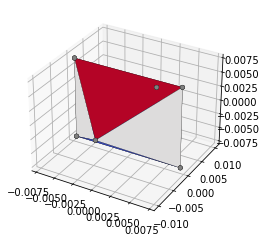

In [208]:
import sys
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple


Triangle = namedtuple("Triangle", "a,b,c")
Point = namedtuple("Point", "x,y,z")


def normalize(p):
    s = sum(u*u for u in p) ** 0.5
    return Point(*(u/s for u in p))


def midpoint(u, v):
    return Point(*((a+b)/2 for a, b in zip(u, v)))


def subdivide_edge(tri, depth):
    if depth == 0:
        yield tri
        return
    #       p0
    #      /  \
    # m01 /....\ m02
    #    / \  / \
    #   /___\/___\
    # p1    m12   p2
    p0, p1, p2 = tri
    m01 = normalize(midpoint(p0, p1))
    m02 = normalize(midpoint(p0, p2))
    m12 = normalize(midpoint(p1, p2))
    triangles = [
        Triangle(p0,  m01, m02),
        Triangle(m01, p1,  m12),
        Triangle(m02, m12, p2),
        Triangle(m01, m02, m12),
    ]
    for t in triangles:
        yield from subdivide_edge(t, depth-1)


def subdivide(faces, depth):
    for tri in faces:
        yield from subdivide_edge(tri, depth)


depth = 0
color = 'coolwarm'

# octahedron
p = 2**0.5 / 2
faces = [
    # top half
    Triangle(Point(0, 1, 0), Point(-p, 0, p), Point( p, 0, p)),
    Triangle(Point(0, 1, 0), Point( p, 0, p), Point( p, 0,-p)),
    Triangle(Point(0, 1, 0), Point( p, 0,-p), Point(-p, 0,-p)),
    Triangle(Point(0, 1, 0), Point(-p, 0,-p), Point(-p, 0, p)),

    # bottom half
    Triangle(Point(0,-1, 0), Point( p, 0, p), Point(-p, 0, p)),
    Triangle(Point(0,-1, 0), Point( p, 0,-p), Point( p, 0, p)),
    Triangle(Point(0,-1, 0), Point(-p, 0,-p), Point( p, 0,-p)),
    Triangle(Point(0,-1, 0), Point(-p, 0, p), Point(-p, 0,-p)),
]

X = []
Y = []
Z = []
T = []

for i, tri in enumerate(subdivide(faces, depth)):
    X.extend([p.x for p in tri])
    Y.extend([p.y for p in tri])
    Z.extend([p.z for p in tri])
    T.append([3*i, 3*i+1, 3*i+2])

X = np.array(X) *0.01
Y = np.array(Y) *0.01
Z = np.array(Z) *0.01

print(len(X))

T = mtri.Triangulation(X, Y, np.array(T))
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(T, Z, lw=0.2, edgecolor="black", color="grey", alpha=1, cmap=color)
ax.scatter(X, Y, Z, lw=0.2, edgecolor="black", color="grey", alpha=1, cmap=color)
# ax.plot_wireframe(x, y, z, color="black", linewidth=0.5, alpha=0.8)
# plt.axis('off')
plt.show()


[((2.0, 3.0, 2.01), (2.005, 3.0, 2.0086602540378444), (2.0, 3.0, 2.01)), ((2.005, 3.0, 2.0086602540378444), (2.0025, 3.004330127018922, 2.0086602540378444), (2.0, 3.0, 2.01)), ((2.005, 3.0, 2.0086602540378444), (2.0086602540378444, 3.0, 2.005), (2.0025, 3.004330127018922, 2.0086602540378444)), ((2.0086602540378444, 3.0, 2.005), (2.004330127018922, 3.0075, 2.005), (2.0025, 3.004330127018922, 2.0086602540378444)), ((2.0086602540378444, 3.0, 2.005), (2.01, 3.0, 2.0), (2.004330127018922, 3.0075, 2.005)), ((2.01, 3.0, 2.0), (2.005, 3.0086602540378444, 2.0), (2.004330127018922, 3.0075, 2.005)), ((2.01, 3.0, 2.0), (2.0086602540378444, 3.0, 1.995), (2.005, 3.0086602540378444, 2.0)), ((2.0086602540378444, 3.0, 1.995), (2.004330127018922, 3.0075, 1.995), (2.005, 3.0086602540378444, 2.0)), ((2.0086602540378444, 3.0, 1.995), (2.005, 3.0, 1.9913397459621556), (2.004330127018922, 3.0075, 1.995)), ((2.005, 3.0, 1.9913397459621556), (2.0025, 3.004330127018922, 1.9913397459621556), (2.004330127018922, 

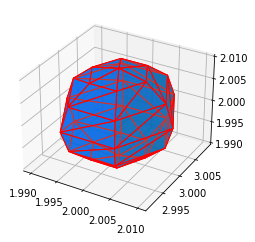

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def create_sphere(num_points=100, center=(0, 0, 0), radius=1.0):
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi, theta = np.meshgrid(phi, theta)

    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return x, y, z

def generate_facets(x, y, z):
    facets = []
    num_points_phi, num_points_theta = x.shape

    for i in range(num_points_phi - 1):
        for j in range(num_points_theta - 1):
            v1 = (x[i, j], y[i, j], z[i, j])
            v2 = (x[i, j + 1], y[i, j + 1], z[i, j + 1])
            v3 = (x[i + 1, j], y[i + 1, j], z[i + 1, j])

            facets.append((v1, v2, v3))

            v1 = (x[i, j + 1], y[i, j + 1], z[i, j + 1])
            v2 = (x[i + 1, j + 1], y[i + 1, j + 1], z[i + 1, j + 1])
            v3 = (x[i + 1, j], y[i + 1, j], z[i + 1, j])

            facets.append((v1, v2, v3))

    return facets

def plot_sphere_with_facets(x, y, z, facets):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, color='b', alpha=0.6, edgecolors='k', linewidth=0.1)

    poly3d = Poly3DCollection(facets, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.2)
    ax.add_collection3d(poly3d)

    plt.show()

if __name__ == "__main__":
    num_points = 7
    center = (2, 3, 2)  # Center position (x, y, z)
    radius = 0.01
    x, y, z = create_sphere(num_points, center, radius)
    facets = generate_facets(x, y, z)
    print(facets)
    plot_sphere_with_facets(x, y, z, facets)


In [366]:
import numpy as np

def create_sphere(num_points=100, center=(0, 0, 0), radius=1.0):
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi, theta = np.meshgrid(phi, theta)

    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return x, y, z

def generate_facets(x, y, z):
    facets = []
    num_points_phi, num_points_theta = x.shape

    for i in range(num_points_phi - 1):
        for j in range(num_points_theta - 1):
            v1 = (x[i, j], y[i, j], z[i, j])
            v2 = (x[i, j + 1], y[i, j + 1], z[i, j + 1])
            v3 = (x[i + 1, j], y[i + 1, j], z[i + 1, j])

            facets.append((v1, v2, v3))

            v1 = (x[i, j + 1], y[i, j + 1], z[i, j + 1])
            v2 = (x[i + 1, j + 1], y[i + 1, j + 1], z[i + 1, j + 1])
            v3 = (x[i + 1, j], y[i + 1, j], z[i + 1, j])

            facets.append((v1, v2, v3))

    return facets

def print_facets(facets):

    for facet in facets:
        aa = []
        for vertex in facet:
            aa.append(np.asarray(vertex))
        aaa = np.concatenate(aa)
        print(aaa)

if __name__ == "__main__":
    num_points = 7
    center = (2, 3, 0)  # Center position (x, y, z)
    radius = 1.0
    x, y, z = create_sphere(num_points, center, radius)
    facets = generate_facets(x, y, z)
    print_facets(facets)



[2.        3.        1.        2.5       3.        0.8660254 2.
 3.        1.       ]
[2.5       3.        0.8660254 2.25      3.4330127 0.8660254 2.
 3.        1.       ]
[2.5       3.        0.8660254 2.8660254 3.        0.5       2.25
 3.4330127 0.8660254]
[2.8660254 3.        0.5       2.4330127 3.75      0.5       2.25
 3.4330127 0.8660254]
[2.8660254e+00 3.0000000e+00 5.0000000e-01 3.0000000e+00 3.0000000e+00
 6.1232340e-17 2.4330127e+00 3.7500000e+00 5.0000000e-01]
[3.0000000e+00 3.0000000e+00 6.1232340e-17 2.5000000e+00 3.8660254e+00
 6.1232340e-17 2.4330127e+00 3.7500000e+00 5.0000000e-01]
[ 3.0000000e+00  3.0000000e+00  6.1232340e-17  2.8660254e+00
  3.0000000e+00 -5.0000000e-01  2.5000000e+00  3.8660254e+00
  6.1232340e-17]
[ 2.8660254e+00  3.0000000e+00 -5.0000000e-01  2.4330127e+00
  3.7500000e+00 -5.0000000e-01  2.5000000e+00  3.8660254e+00
  6.1232340e-17]
[ 2.8660254  3.        -0.5        2.5        3.        -0.8660254
  2.4330127  3.75      -0.5      ]
[ 2.5        3